In [12]:
# ============================================================
# h-BN 5×5 Defect Generator (Clean Folder Layout)
# Jupyter + Script Compatible
# Saves: CIF + XYZ + TRAJ (per-structure folders)
# Author: Dennis Wayo
# ============================================================

import os
import numpy as np
from ase import Atoms
from ase.build import make_supercell
from ase.io import write

# =========================
# CONFIGURATION
# =========================
A_LAT = 2.50       # lattice constant (Å)
VACUUM = 20.0      # vacuum along z (Å) — safe for GPAW / TDDFT
SUPERCELL = 5
PREFIX = "hBN_5x5"

BASE_DIR = os.getcwd()   # works in Jupyter & .py


# =========================
# BUILD PRIMITIVE h-BN
# =========================
cell = [
    [A_LAT, 0.0, 0.0],
    [-A_LAT / 2, A_LAT * np.sqrt(3) / 2, 0.0],
    [0.0, 0.0, VACUUM],
]

scaled_positions = [
    (0.0, 0.0, 0.0),        # B
    (1/3, 2/3, 0.0),        # N
]

primitive = Atoms(
    symbols="BN",
    scaled_positions=scaled_positions,
    cell=cell,
    pbc=(True, True, False),
)

primitive.center(axis=2, vacuum=VACUUM)


# =========================
# BUILD 5×5 SUPERCELL
# =========================
P = [[SUPERCELL, 0, 0],
     [0, SUPERCELL, 0],
     [0, 0, 1]]

slab = make_supercell(primitive, P)
slab.center(axis=2, vacuum=VACUUM)


# =========================
# HELPERS
# =========================
def first_index(atoms, symbol):
    for i, a in enumerate(atoms):
        if a.symbol == symbol:
            return i
    raise ValueError(f"No atom with symbol '{symbol}' found.")


def save_variant(atoms, name):
    folder = os.path.join(BASE_DIR, name)
    os.makedirs(folder, exist_ok=True)

    write(os.path.join(folder, f"{name}.cif"), atoms)
    write(os.path.join(folder, f"{name}.xyz"), atoms)
    write(os.path.join(folder, f"{name}.traj"), atoms)

    print(f"Saved: {name} (.cif / .xyz / .traj)")


# =========================
# GENERATE STRUCTURES
# =========================

# --- Pristine ---
save_variant(slab, f"{PREFIX}_pristine")

# --- N vacancy (V_N) ---
VN = slab.copy()
VN.pop(first_index(VN, "N"))
save_variant(VN, f"{PREFIX}_VN")

# --- B vacancy (V_B) ---
VB = slab.copy()
VB.pop(first_index(VB, "B"))
save_variant(VB, f"{PREFIX}_VB")

# --- Carbon substitution at N site (C_N) ---
CN = slab.copy()
CN[first_index(CN, "N")].symbol = "C"
save_variant(CN, f"{PREFIX}_CN")

# --- Carbon substitution at B site (C_B) ---
CB = slab.copy()
CB[first_index(CB, "B")].symbol = "C"
save_variant(CB, f"{PREFIX}_CB")

# --- Carbon + N vacancy (C–VN) ---
CVN = slab.copy()
CVN.pop(first_index(CVN, "N"))
CVN[first_index(CVN, "B")].symbol = "C"
save_variant(CVN, f"{PREFIX}_C-VN")

print("\n All h-BN defect structures generated and neatly organized.")

Saved: hBN_5x5_pristine (.cif / .xyz / .traj)
Saved: hBN_5x5_VN (.cif / .xyz / .traj)
Saved: hBN_5x5_VB (.cif / .xyz / .traj)
Saved: hBN_5x5_CN (.cif / .xyz / .traj)
Saved: hBN_5x5_CB (.cif / .xyz / .traj)
Saved: hBN_5x5_C-VN (.cif / .xyz / .traj)

 All h-BN defect structures generated and neatly organized.


In [15]:
#!/usr/bin/env python3
# ============================================================
# SERIAL TDDFT PIPELINE (DEFECT-FOLDER AWARE — LOCAL MAC VERSION)
# LCAO → FD → LR-TDDFT
# - Recursively scans defect folders
# - Prefers CIF inputs, falls back to XYZ
# - Saves outputs inside each defect folder
# - Recommends: symmetry="off" for slabs, spinpol for vacancy-like defects
# Author: Dennis Wayo — Nov 2025 (clean upgraded version)
# ============================================================
import os
os.environ["GPAW_MPI"] = "no"   # MUST be set before importing gpaw
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import os
import glob
import time
import warnings
import logging

import numpy as np

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from ase.io import read, write
from ase.optimize import LBFGS

from gpaw import GPAW, FermiDirac
from gpaw.lrtddft import LrTDDFT

# Prevent GPAW from using MPI internally
os.environ["GPAW_MPI"] = "no"

warnings.filterwarnings("ignore")

# ============================================================
# SERIAL: single-rank setup
# ============================================================
rank = 0
size = 1

# ------------------------------------------------------------
# WORKDIR + LOG DIRECTORY (AUTO-DETECT PROJECT DIR)
# ------------------------------------------------------------
try:
    WORKDIR = os.path.dirname(os.path.abspath(__file__))  # .py
except NameError:
    WORKDIR = os.getcwd()  # Jupyter

LOGDIR = os.path.join(WORKDIR, "logs")
os.makedirs(LOGDIR, exist_ok=True)

# ------------------------------------------------------------
# LOGGING SETUP (single log file)
# ------------------------------------------------------------
def setup_logger() -> logging.Logger:
    logger = logging.getLogger("serial")
    if logger.handlers:
        return logger

    logger.setLevel(logging.INFO)
    fh = logging.FileHandler(os.path.join(LOGDIR, "serial.log"), mode="w")
    fmt = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
    fh.setFormatter(fmt)
    logger.addHandler(fh)
    logger.propagate = False
    return logger

logger = setup_logger()

print("\nTDDFT pipeline started (local machine)\n", flush=True)
logger.info("SERIAL execution (MPI disabled)")

# ------------------------------------------------------------
# SET WORKDIR
# ------------------------------------------------------------
os.chdir(WORKDIR)
print(f"Working directory: {WORKDIR}", flush=True)
logger.info(f"Working directory set to {WORKDIR}")

# ============================================================
# DEFECT FOLDER SCAN
# - Looks for folders that contain one structure file:
#   <folder>/<folder>.cif (preferred) or <folder>/<folder>.xyz
# ============================================================
def find_defect_jobs(base_dir: str):
    jobs = []
    # candidate folders: anything in WORKDIR that is a directory
    for d in sorted(glob.glob(os.path.join(base_dir, "*"))):
        if not os.path.isdir(d):
            continue
        name = os.path.basename(d)

        cif = os.path.join(d, f"{name}.cif")
        xyz = os.path.join(d, f"{name}.xyz")

        if os.path.exists(cif):
            jobs.append((name, d, cif))
        elif os.path.exists(xyz):
            jobs.append((name, d, xyz))

    return jobs

jobs = find_defect_jobs(WORKDIR)

print(f"Found {len(jobs)} defect folders.", flush=True)
logger.info(f"Found {len(jobs)} defect folders: {[j[0] for j in jobs]}")

if not jobs:
    print("No defect folders found. Exiting.", flush=True)
    raise SystemExit

# ------------------------------------------------------------
# Spin rules (recommended)
# - vacancies and C–VN often need spin polarization
# ------------------------------------------------------------
def needs_spinpol(struct_name: str) -> bool:
    key = struct_name.lower()
    # You can expand this rule if you add more defect types later
    return any(tag in key for tag in ["_vn", "_vb", "c-vn"])

# ============================================================
# 1 — LCAO RELAXATION
# ============================================================
def relax_lcao(struct_name: str, folder: str, inpath: str) -> str:
    out_gpw = os.path.join(folder, f"{struct_name}_lcao.gpw")

    if os.path.exists(out_gpw):
        print(f"✔ Cached LCAO: {out_gpw}", flush=True)
        return out_gpw

    print(f"LCAO → {struct_name}", flush=True)

    atoms = read(inpath)
    atoms.center(axis=2, vacuum=20.0)

    calc = GPAW(
        mode="lcao",
        basis="dzp",
        xc="PBE",
        occupations=FermiDirac(0.05),
        kpts=(1, 1, 1),
        symmetry="off",
        spinpol=needs_spinpol(struct_name),
        txt=os.path.join(folder, f"{struct_name}_lcao.log"),
    )

    atoms.calc = calc
    opt = LBFGS(atoms, logfile=os.path.join(folder, f"{struct_name}_opt.log"))
    opt.run(fmax=0.10, steps=200)

    calc.write(out_gpw, mode="all")

    write(os.path.join(folder, f"{struct_name}_relaxed.xyz"), atoms)
    write(os.path.join(folder, f"{struct_name}_relaxed.cif"), atoms)

    return out_gpw

# ============================================================
# 2 — FD RESTART
# ============================================================
def fd_restart(struct_name: str, folder: str, gpw_lcao: str,
               virt_buffer: int = 10) -> str:

    out_fd = os.path.join(folder, f"{struct_name}_fd.gpw")

    if os.path.exists(out_fd):
        print(f"✔ Cached FD: {out_fd}", flush=True)
        return out_fd

    print(f"FD restart → {struct_name}", flush=True)

    lcao = GPAW(gpw_lcao)
    n_e = lcao.get_number_of_electrons()
    nbands = int((n_e // 2) + virt_buffer)

    calc = GPAW(
        gpw_lcao,
        mode="fd",
        h=0.25,
        xc="PBE",
        nbands=nbands,
        occupations=FermiDirac(0.1),
        symmetry="off",
        spinpol=needs_spinpol(struct_name),
        convergence={"density": 5e-3, "energy": 5e-3},
        txt=os.path.join(folder, f"{struct_name}_fd.log"),
    )

    calc.get_potential_energy()
    calc.write(out_fd, mode="all")

    return out_fd


# ============================================================
# 3 — LR-TDDFT
# ============================================================
def run_tddft(struct_name: str, folder: str, gpw_fd: str,
              emax=6.0, sigma=0.1):

    csv = os.path.join(folder, f"{struct_name}_spectrum.csv")
    png = os.path.join(folder, f"{struct_name}_spectrum.png")
    tlog = os.path.join(folder, f"{struct_name}_lrtddft.log")

    if os.path.exists(csv) and os.path.exists(png):
        print(f"✔ Cached TDDFT: {struct_name}", flush=True)
        return csv, png

    print(f"TDDFT → {struct_name}", flush=True)

    # --------------------------------------------------
    # Ensure TDDFT log file is writable (macOS-safe)
    # --------------------------------------------------
    with open(tlog, "w") as f:
        f.write(f"LR-TDDFT log for {struct_name}\n")

    # --------------------------------------------------
    # Reopen ground state
    # --------------------------------------------------
    calc = GPAW(gpw_fd)

    nk = len(calc.wfs.kd.bzk_kc)
    print(f"    [TDDFT check] len(bzk_kc) = {nk}", flush=True)
    if nk != 1:
        raise RuntimeError("LR-TDDFT requires Γ-only ground state")

    # --------------------------------------------------
    # LEGACY-COMPATIBLE LR-TDDFT
    # --------------------------------------------------
    lr = LrTDDFT(calc, txt=tlog)
    lr.diagonalize()

    # --------------------------------------------------
    # Extract spectrum
    # --------------------------------------------------
    energies, osc = [], []
    for exc in lr:
        e_ev = exc.get_energy() * 27.2114  # Ha → eV
        if e_ev <= emax:
            energies.append(e_ev)
            osc.append(np.linalg.norm(exc.get_oscillator_strength()))

    energies = np.array(energies)
    osc = np.array(osc)

    np.savetxt(
        csv,
        np.column_stack([energies, osc]),
        delimiter=",",
        header="Energy(eV),Osc",
        comments="",
    )

    # --------------------------------------------------
    # Plot spectrum
    # --------------------------------------------------
    x = np.linspace(0.0, emax, 2000)
    y = np.zeros_like(x)
    for e, f in zip(energies, osc):
        y[np.argmin(np.abs(x - e))] += f
    y = gaussian_filter1d(y, sigma * 80)

    plt.figure()
    plt.plot(x, y)
    plt.scatter(energies, osc, s=10)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Oscillator Strength")
    plt.title(struct_name)
    plt.tight_layout()
    plt.savefig(png, dpi=300)
    plt.close()

    return csv, png

# ============================================================
# PIPELINE
# ============================================================
success = 0
fail = 0
t_start = time.time()

for i, (name, folder, inpath) in enumerate(jobs, start=1):
    print(f"\n→ Start {name} ({i}/{len(jobs)}) | folder={os.path.basename(folder)}", flush=True)
    try:
        gpw_lcao = relax_lcao(name, folder, inpath)
        gpw_fd = fd_restart(name, folder, gpw_lcao)
        run_tddft(name, folder, gpw_fd)
        success += 1
    except Exception as e:
        fail += 1
        logger.error(f"Error for {name}: {e}")
        print(f"⚠ Failed {name}: {e}", flush=True)

t_end = time.time()

# ============================================================
# SUMMARY
# ============================================================
print("\n================ SERIAL SUMMARY ================", flush=True)
print(f"Total structures        : {len(jobs)}")
print(f"Successful spectra      : {success}")
print(f"Failed structures       : {fail}")
print(f"Wallclock time          : {(t_end - t_start)/60:.1f} min")
print("===============================================\n", flush=True)

merged_csv = os.path.join(WORKDIR, "all_spectra_merged.csv")
spectra_files = sorted(glob.glob(os.path.join(WORKDIR, "*", "*_spectrum.csv")))

with open(merged_csv, "w") as fout:
    fout.write("Molecule,Energy(eV),Osc\n")
    for fcsv in spectra_files:
        mol = os.path.basename(fcsv).replace("_spectrum.csv", "")
        try:
            data = np.loadtxt(fcsv, delimiter=",", skiprows=1)
            if data.ndim == 1:
                data = data[None, :]
            for E, F in data:
                fout.write(f"{mol},{E:.6f},{F:.6f}\n")
        except Exception as e:
            print(f"Could not merge {fcsv}: {e}")

print("\n TDDFT PIPELINE FINISHED\n", flush=True)
print(f"Merged spectra saved → {merged_csv}", flush=True)


TDDFT pipeline started (local machine)

Working directory: /Users/denniswayo/gpaw-DFT/emitter2chip
Found 6 defect folders.

→ Start hBN_5x5_C-VN (1/6) | folder=hBN_5x5_C-VN
✔ Cached LCAO: /Users/denniswayo/gpaw-DFT/emitter2chip/hBN_5x5_C-VN/hBN_5x5_C-VN_lcao.gpw
✔ Cached FD: /Users/denniswayo/gpaw-DFT/emitter2chip/hBN_5x5_C-VN/hBN_5x5_C-VN_fd.gpw
TDDFT → hBN_5x5_C-VN
    [TDDFT check] len(bzk_kc) = 1

→ Start hBN_5x5_CB (2/6) | folder=hBN_5x5_CB
✔ Cached LCAO: /Users/denniswayo/gpaw-DFT/emitter2chip/hBN_5x5_CB/hBN_5x5_CB_lcao.gpw
✔ Cached FD: /Users/denniswayo/gpaw-DFT/emitter2chip/hBN_5x5_CB/hBN_5x5_CB_fd.gpw
TDDFT → hBN_5x5_CB
    [TDDFT check] len(bzk_kc) = 1
Memory usage: 1.89 GiB
Date: Fri Dec 19 11:40:09 2025

→ Start hBN_5x5_CN (3/6) | folder=hBN_5x5_CN
✔ Cached LCAO: /Users/denniswayo/gpaw-DFT/emitter2chip/hBN_5x5_CN/hBN_5x5_CN_lcao.gpw
✔ Cached FD: /Users/denniswayo/gpaw-DFT/emitter2chip/hBN_5x5_CN/hBN_5x5_CN_fd.gpw
TDDFT → hBN_5x5_CN
    [TDDFT check] len(bzk_kc) = 1

→ Star

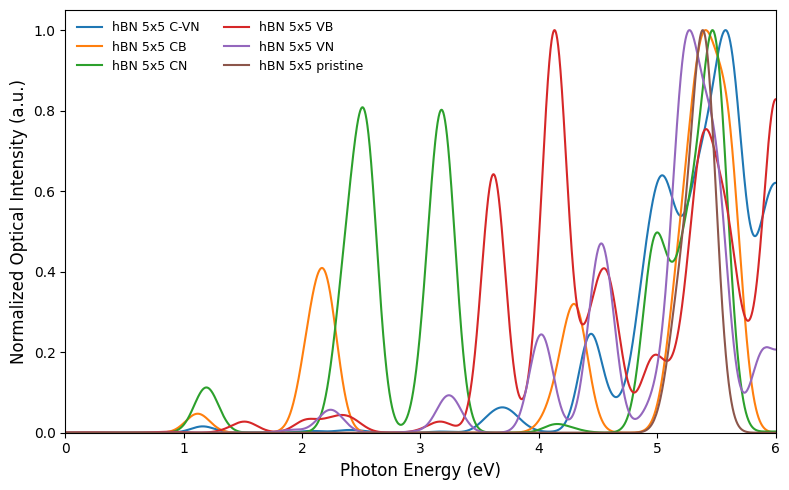

Saved overlay spectrum → hBN_defect_spectra_overlay.png


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ==============================
# USER SETTINGS
# ==============================
CSV_FILE = "all_spectra_merged.csv"
EMAX = 6.0                 # eV
NPTS = 4000                # energy grid resolution
SIGMA_EV = 0.10            # Gaussian broadening (eV)
OUTPUT = "hBN_defect_spectra_overlay.png"

# ==============================
# LOAD DATA
# ==============================
df = pd.read_csv(CSV_FILE)

systems = sorted(df["Molecule"].unique())

# Energy grid
E = np.linspace(0.0, EMAX, NPTS)

plt.figure(figsize=(8, 5))

# ==============================
# LOOP OVER DEFECTS
# ==============================
for system in systems:
    sub = df[df["Molecule"] == system]

    spectrum = np.zeros_like(E)

    for _, row in sub.iterrows():
        idx = np.argmin(np.abs(E - row["Energy(eV)"]))
        spectrum[idx] += row["Osc"]

    # Gaussian broadening
    sigma_pts = SIGMA_EV / (E[1] - E[0])
    spectrum = gaussian_filter1d(spectrum, sigma_pts)

    # Normalize for comparison
    if spectrum.max() > 0:
        spectrum /= spectrum.max()

    plt.plot(E, spectrum, label=system.replace("_", " "))

# ==============================
# PLOT STYLING
# ==============================
plt.xlabel("Photon Energy (eV)", fontsize=12)
plt.ylabel("Normalized Optical Intensity (a.u.)", fontsize=12)
plt.xlim(0, EMAX)
plt.ylim(0, 1.05)

plt.legend(frameon=False, fontsize=9, ncol=2)
plt.tight_layout()

# ==============================
# SAVE FIGURE
# ==============================
plt.savefig(OUTPUT, dpi=300)
plt.show()

print(f"Saved overlay spectrum → {OUTPUT}")

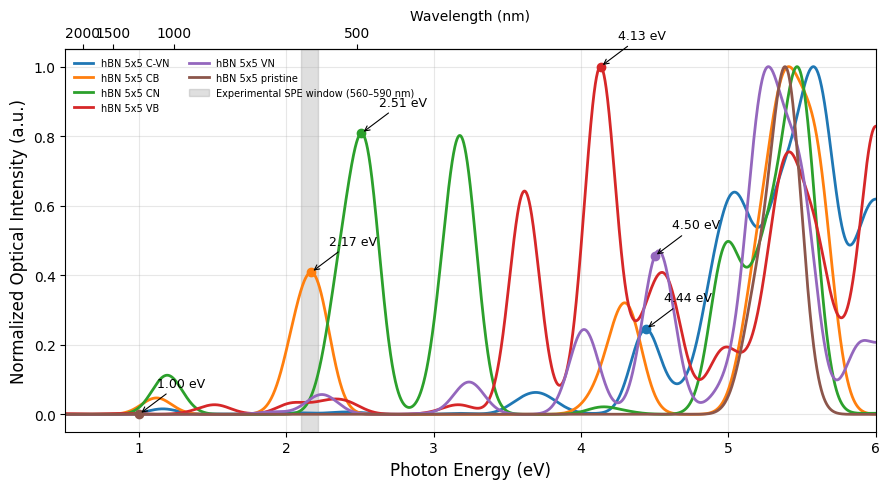

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load merged TDDFT transitions
df = pd.read_csv("all_spectra_merged.csv")

# Energy grid for plotting
Emin, Emax = 0.5, 6.0
Egrid = np.linspace(Emin, Emax, 3000)

# Broadening (≈ 0.1 eV)
sigma_eV = 0.10
sigma_pts = sigma_eV / (Egrid[1] - Egrid[0])

HC = 1239.84193  # eV·nm

def eV_to_nm(E):
    E = np.asarray(E)
    return HC / np.clip(E, 1e-6, None)

def nm_to_eV(lam):
    lam = np.asarray(lam)
    return HC / np.clip(lam, 1e-6, None)
spectra = {}

for name, group in df.groupby("Molecule"):
    y = np.zeros_like(Egrid)

    for E, f in zip(group["Energy(eV)"], group["Osc"]):
        idx = np.argmin(np.abs(Egrid - E))
        y[idx] += f

    # Gaussian broadening
    y = gaussian_filter1d(y, sigma_pts)

    # Normalize for comparison
    if y.max() > 0:
        y /= y.max()

    spectra[name] = y


fig, ax = plt.subplots(figsize=(9, 5))

colors = {
    "hBN_5x5_C-VN": "tab:blue",
    "hBN_5x5_CB": "tab:orange",
    "hBN_5x5_CN": "tab:green",
    "hBN_5x5_VB": "tab:red",
    "hBN_5x5_VN": "tab:purple",
    "hBN_5x5_pristine": "tab:brown",
}

for name, y in spectra.items():
    label = name.replace("_", " ")
    ax.plot(Egrid, y, lw=2, label=label, color=colors.get(name, None))

    # ---- ZPL candidate: lowest-energy bright peak
    mask = (Egrid > 1.0) & (Egrid < 4.5)
    idx_zpl = np.argmax(y[mask])
    Ezpl = Egrid[mask][idx_zpl]
    Izpl = y[mask][idx_zpl]

    ax.plot(Ezpl, Izpl, "o", color=colors.get(name, "black"))
    ax.annotate(
        f"{Ezpl:.2f} eV",
        xy=(Ezpl, Izpl),
        xytext=(Ezpl + 0.12, Izpl + 0.08),
        arrowprops=dict(arrowstyle="->", lw=0.8),
        fontsize=9,
    )

# Experimental SPE window: 560–590 nm
E_min = nm_to_eV(590)
E_max = nm_to_eV(560)

ax.axvspan(
    E_min, E_max,
    color="gray",
    alpha=0.25,
    label="Experimental SPE window (560–590 nm)"
)

# Axes
ax.set_xlim(Emin, Emax)
ax.set_xlabel("Photon Energy (eV)", fontsize=12)
ax.set_ylabel("Normalized Optical Intensity (a.u.)", fontsize=12)

# Secondary wavelength axis
secax = ax.secondary_xaxis("top", functions=(eV_to_nm, nm_to_eV))
secax.set_xlabel("Wavelength (nm)", fontsize=10)

ax.legend(ncol=2, fontsize=7, frameon=False)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("hBN_defect_spectra_ZPL_annotated.png", dpi=300)
plt.show()

